# Dynamics Homework 2

Liam Dubay

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
G = 4*np.pi**2 # solar system units

In [22]:
class Binary:
    def __init__(self, mass1, mass2, separation, phase=0):
        """
        Parameters
        ----------
        mass1 : float
            Mass of primary star in solar masses
        mass2 : float
            Mass of secondary star in solar masses
        separation : float
            Separation of binary in AU
        phase : float
            Initial phase of binary from 0 to 1. A phase of 0 
            starts the primary mass on the positive x-axis.
        
        """
        self.m1 = mass1
        self.m2 = mass2
        self.a1 = mass1 / (mass1 + mass2) * separation
        self.a2 = mass2 / (mass1 + mass2) * separation
        # Convert phase to angle
        self.phi0 = phase * 2*np.pi
        self.T = np.sqrt(separation**3/(self.m1 + self.m2))
        
    def acceleration(self, t, test_position):
        """
        Gravitational acceleration on a test particle due to the binary.
        """
        pos1, pos2 = self.positions(t)
        r1 = test_position - pos1
        r2 = test_position - pos2
        accel = -G * (self.m1 * r1 / np.sqrt(np.sum(r1**2))**3 + self.m2 * r2 / np.sqrt(np.sum(r2**2))**3)
        return accel
    
    def positions(self, t):
        """
        Cartesian positions of the two masses as a function of time.
        """
        # Orbital phase of the primary, m1
        phi = 2*np.pi/self.T * t + self.phi0
        # Keep phase < 2pi
        phi = phi - 2*np.pi * np.floor(phi / (2*np.pi))
        # Cartesian positions of m1 and m2
        pos1 = self.a1 * np.array([np.cos(phi), np.sin(phi)])
        pos2 = self.a2 * np.array([np.cos(phi+np.pi), np.sin(phi+np.pi)])
        return pos1, pos2
        
    def potential(self, t, test_position):
        """
        Gravitational potential of a test particle at a given position and time.
        """
        pos1, pos2 = self.positions(t)
        r1 = np.sqrt(np.sum((test_position - pos1)**2))
        r2 = np.sqrt(np.sum((test_position - pos2)**2))
        pot = -G * (self.m1 / r1 + self.m2 / r2)
        return pot

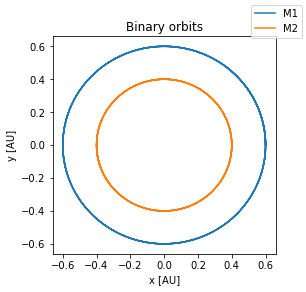

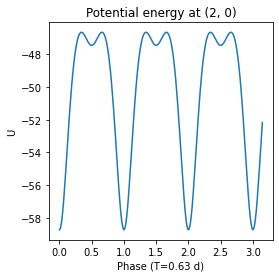

In [29]:
# Test code for binary star
binary = Binary(1.5, 1, 1, phase=0)
tarr = np.arange(0, 2, 0.01)

# Plot orbits
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(binary.positions(tarr)[0][0], binary.positions(tarr)[0][1], label='M1')
ax.plot(binary.positions(tarr)[1][0], binary.positions(tarr)[1][1], label='M2')
ax.set_title('Binary orbits')
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
fig.legend()
plt.show()

# Plot potential energy at test position
test_pos = np.array([2, 0])
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(tarr / binary.T, [binary.potential(t, test_pos) for t in tarr])
ax.set_title('Potential energy at (2, 0)')
ax.set_xlabel(f'Phase (T={binary.T:.02f} d)' % binary.T)
ax.set_ylabel('U')
plt.show()

In [ ]:
class TestParticle():
    """Parameters, values, and functions for an individual celestial body."""
    
    def __init__(self, mass, x_init, y_init, xdot_init, ydot_init, name=''):
        """
        Initialize celestial body with values for mass [solar masses], initial position [AU], and initial velocity [AU/yr].
        """
        
        self.name = name
        # Check if mass is a function, then evaulate at t=0
        if callable(mass):
            self.mass_is_func = True
            self.mass_func = mass
            self.mass = self.mass_func(0)
        else:
            self.mass_is_func = False
            self.mass = mass
        self.position = np.array([x_init, y_init], dtype=float)
        self.velocity = np.array([xdot_init, ydot_init], dtype=float)
        
    def accelerate(self, tstep, acceleration, update=True):
        """
        Accelerate body by specified time step according to current position.
        
        Parameters
        ----------
        tstep : float, time step dt
        acceleration : np.Array, acceleration vector [xdd, ydd]
        update : bool, if True update this body's position
        """
        
        velocity = self.velocity + acceleration * tstep
        if update:
            self.velocity = velocity
        return velocity
    
    def kinetic_energy(self):
        """
        Calculate kinetic energy of body.
        """
        
        return 0.5 * self.mass * np.sum(self.velocity**2)

    def move(self, tstep, update=True):
        """
        Move position by specified time step according to current velocity.
        
        Parameters
        ----------
        tstep : float, time step dt
        update : bool, if True update this body's position
        """
        
        position = self.position + self.velocity * tstep
        if update:
            self.position = position
        return position